In [49]:
import numpy as np
from numpy import mean
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from imblearn.over_sampling import SMOTE
from imblearn.metrics import geometric_mean_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
%matplotlib inline

In [2]:
data = pd.read_csv("bank-additional-full.csv", sep=';')

In [3]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
data.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
age               41188 non-null int64
job               41188 non-null object
marital           41188 non-null object
education         41188 non-null object
default           41188 non-null object
housing           41188 non-null object
loan              41188 non-null object
contact           41188 non-null object
month             41188 non-null object
day_of_week       41188 non-null object
duration          41188 non-null int64
campaign          41188 non-null int64
pdays             41188 non-null int64
previous          41188 non-null int64
poutcome          41188 non-null object
emp.var.rate      41188 non-null float64
cons.price.idx    41188 non-null float64
cons.conf.idx     41188 non-null float64
euribor3m         41188 non-null float64
nr.employed       41188 non-null float64
y                 41188 non-null object
dtypes: float64(5), int64(5), object(11)
memory usa

In [6]:
data.drop('duration',axis=1,inplace=True)

In [7]:
numerical_variables = [column for column in data.describe().columns]
numerical_variables

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [8]:
categorical_variables = []
for col in data.columns:
    if col not in numerical_variables:
        categorical_variables.append(col)
        
target = categorical_variables[-1]
categorical_variables = categorical_variables[:-1]
categorical_variables

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'poutcome']

In [9]:
negative_samples = len(data[data[target] == 'no'])
positive_samples = len(data[data[target] == 'yes'])

print('no examples ', negative_samples)
print('yes examples ', positive_samples)

no examples  36548
yes examples  4640


In [10]:
print('percentage of negative samples ', (negative_samples/len(data)) * 100)
print('percentage of positive samples ', (positive_samples/len(data)) * 100)

percentage of negative samples  88.73458288821988
percentage of positive samples  11.265417111780131


Imbalanced dataset but around 1:10 ratio is not the worst
False positive and false negative both important for this problem so i will use a F1 metric score

In [11]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data[target] = le.fit_transform(data[target])

In [12]:
# train test split is stratified because of imbalanced dataset
train, test = train_test_split(data, stratify=data['y'],random_state=42)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026697FCA288>,
      dtype=object)

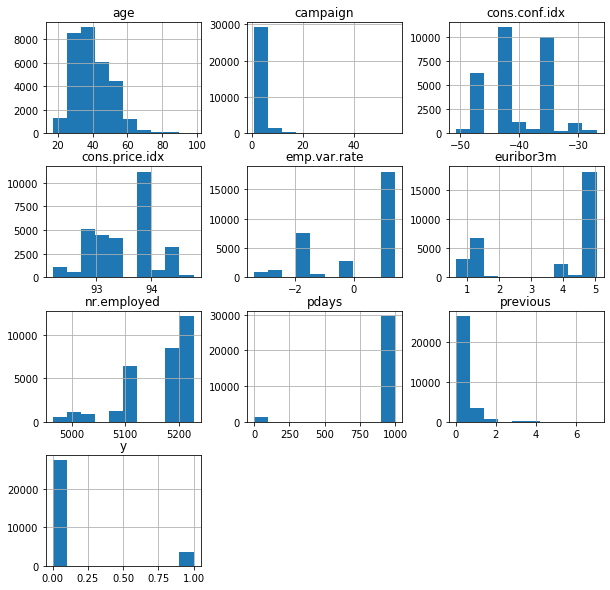

In [13]:
#histogram for numerical values
train.hist(figsize=(10,10))

age looks like skewed gaussian. campaign and previous possibly exponential. may want to remove pdays 999 attribute and make it a separate variable or keep ones with 999 and make categorical variable for actual numbers. Duration should be removed according to the data description to produce a realistic model.

In [14]:
def category_analysis(category, data):
    plt.figure(figsize=(10,10))

    sns.catplot(category, hue="y", data=data, kind="count", 
                palette={0:"blue", 1:"green"})

    plt.xlabel(category,fontsize=10)

    plt.xticks(rotation=40, ha='right')
    plt.tight_layout()

    plt.suptitle(f"{category} vs term deposit");
    plt.show()

<Figure size 720x720 with 0 Axes>

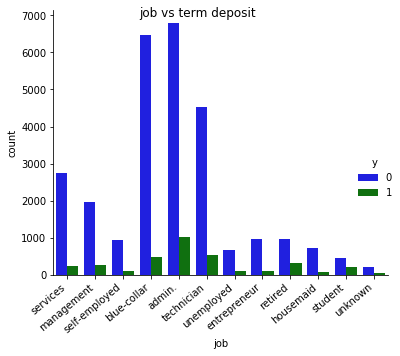

<Figure size 720x720 with 0 Axes>

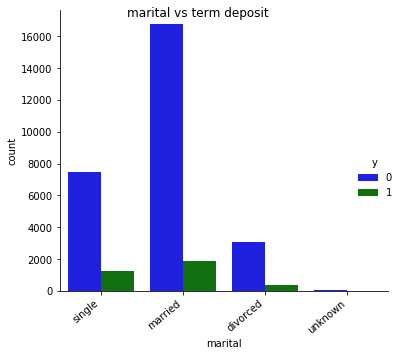

<Figure size 720x720 with 0 Axes>

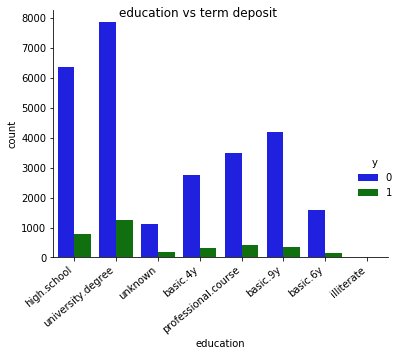

<Figure size 720x720 with 0 Axes>

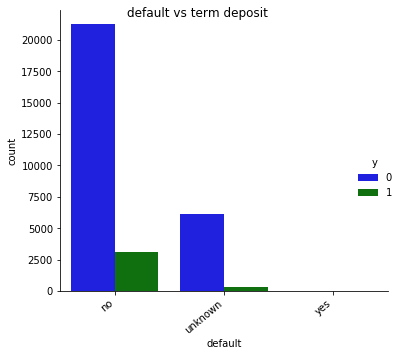

<Figure size 720x720 with 0 Axes>

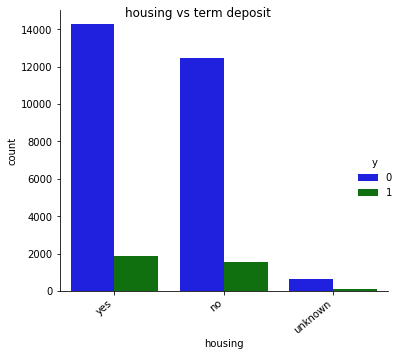

<Figure size 720x720 with 0 Axes>

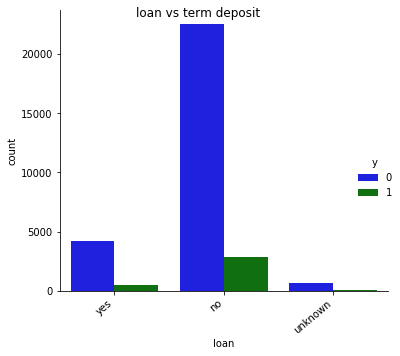

<Figure size 720x720 with 0 Axes>

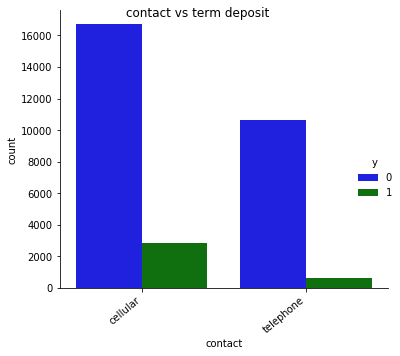

<Figure size 720x720 with 0 Axes>

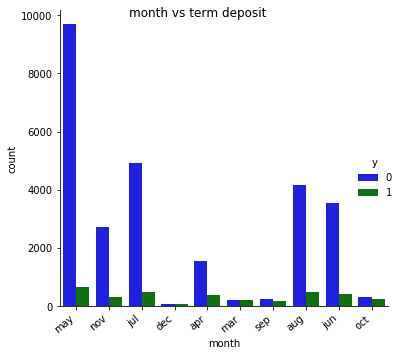

<Figure size 720x720 with 0 Axes>

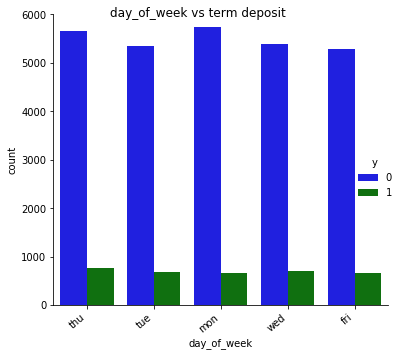

<Figure size 720x720 with 0 Axes>

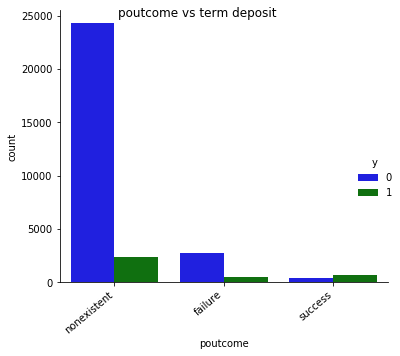

In [15]:
for col in categorical_variables:
    category_analysis(col, train)

relative to total, students and retirees seem more likely to make a term deposit, iliterate doesnt seem to have any representation at all, day of the week seems even across all days,  March has more term deposits than not, if poutcome is a success than they are more likely to be make a term deposit

In [16]:
train['previous'].value_counts()

0    26618
1     3459
2      577
3      161
4       57
5       13
6        5
7        1
Name: previous, dtype: int64

<Figure size 720x720 with 0 Axes>

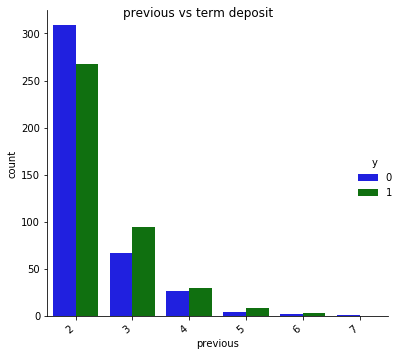

In [17]:
category_analysis('previous', train[train['previous'] > 1])

if client was contacted more than once it seems more likely to make a deposit.

<Figure size 720x720 with 0 Axes>

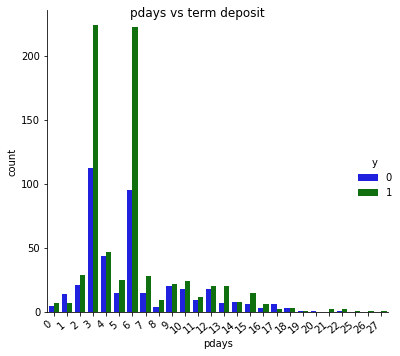

In [18]:
category_analysis('pdays', train[train['pdays'] != 999])

<Figure size 720x720 with 0 Axes>

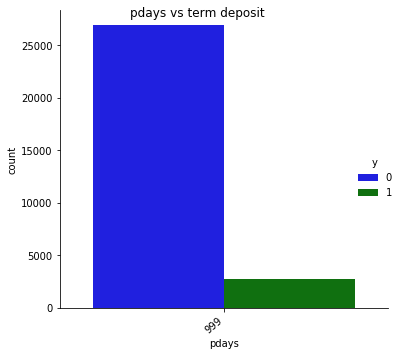

In [19]:
category_analysis('pdays', train[train['pdays'] == 999])

This looks like if the client was contacted since the previous campaign, they were more likely to make a deposit, so we can make a categorical variable to seperate from the majority 999 value which means they were not contacted.

<Figure size 720x720 with 0 Axes>

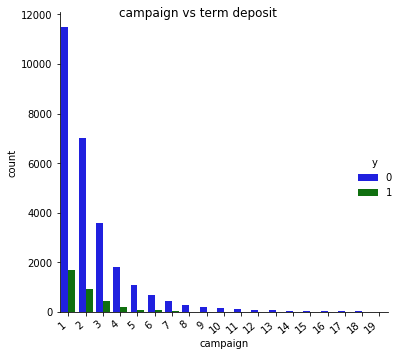

In [20]:
category_analysis('campaign',train[train['campaign'] < 20])

<Figure size 720x720 with 0 Axes>

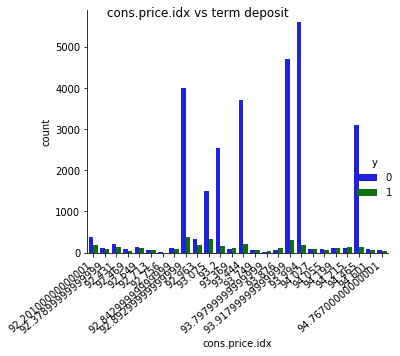

In [21]:
category_analysis('cons.price.idx',train)

(array([  580.,     0.,     0.,  5663.,  9278., 11040.,  4074.,   162.,
            0.,    94.]),
 array([-5.19933758e+00, -4.15947007e+00, -3.11960255e+00, -2.07973503e+00,
        -1.03986752e+00,  4.89217555e-11,  1.03986752e+00,  2.07973503e+00,
         3.11960255e+00,  4.15947007e+00,  5.19933758e+00]),
 <a list of 10 Patch objects>)

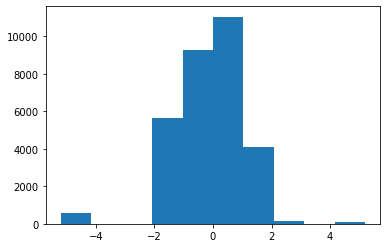

In [22]:
qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal')
t = qt.fit_transform(train['cons.price.idx'].values.reshape(-1,1))
# train['cons.price.idx'].hist()
plt.hist(t)

can try applying transform to cons.price.idx to look for gaussian

<Figure size 720x720 with 0 Axes>

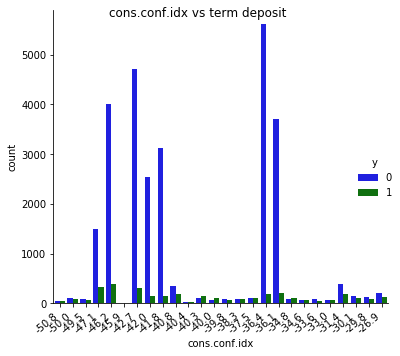

In [23]:
category_analysis('cons.conf.idx',train)

(array([   94.,     0.,   374.,  6206.,  7720., 10617.,  5341.,   202.,
            0.,   337.]),
 array([-5.19933758e+00, -4.15947007e+00, -3.11960255e+00, -2.07973503e+00,
        -1.03986752e+00,  4.89217555e-11,  1.03986752e+00,  2.07973503e+00,
         3.11960255e+00,  4.15947007e+00,  5.19933758e+00]),
 <a list of 10 Patch objects>)

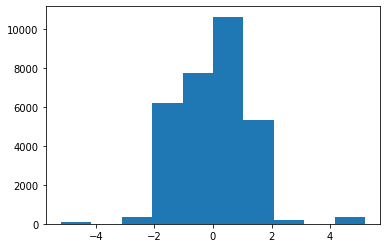

In [24]:
qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal')
t = qt.fit_transform(train['cons.conf.idx'].values.reshape(-1,1))
plt.hist(t)

cons.conf.idx can be transformed to look more gaussian

<Figure size 720x720 with 0 Axes>

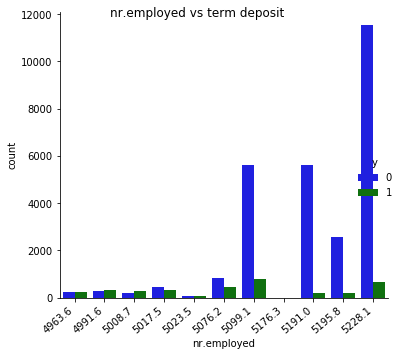

In [25]:
category_analysis('nr.employed',train)

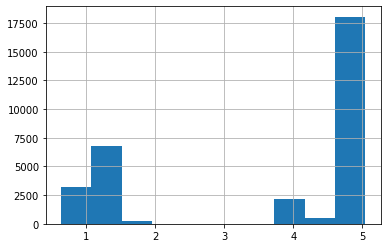

In [26]:
train['euribor3m'].hist()

<Figure size 720x720 with 0 Axes>

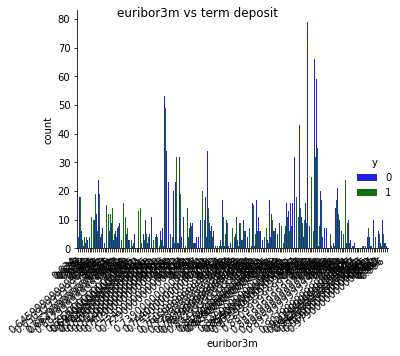

In [27]:
category_analysis('euribor3m',train[train['euribor3m'] < 1])

seems to be a split around 3, and if lower than two, closer to 1, there is a lot more deposits made

# Feature Engineering

In [28]:
#function to check if client was contacted more than once
def prev_more_than1(row):
    if row['previous'] > 1:
        return 1
    return 0

# make categorical feature based on training data
train['prev_more_than1'] = train.apply(lambda row : prev_more_than1(row),axis=1)
test['prev_more_than1'] = test.apply(lambda row : prev_more_than1(row),axis=1)
categorical_variables.append('prev_more_than1')
# numerical_variables.remove('previous')

C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [29]:
#function to check if client was contacted within 30 days since previous campaign
def contacted_30(row):
    if row['pdays'] >= 30:
        return 0
    return 1

#make categorical feature based on training data
train['contacted_30'] = train.apply(lambda row : contacted_30(row),axis=1)
# train.drop(labels = ['pdays'],axis=1,inplace=True)
test['contacted_30'] = test.apply(lambda row : contacted_30(row),axis=1)
# test.drop(labels = ['pdays'],axis=1,inplace=True)
categorical_variables.append('contacted_30')
# numerical_variables.remove('pdays')

C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [30]:
#function to check if euribor3m variable is less than2 or greater than 2
def euribor_less1(row):
    if row['euribor3m'] > 2:
        return 0
    return 1

#make categorical feature based on training data
train['euribor_less1'] = train.apply(lambda row : euribor_less1(row),axis=1)
# train.drop(labels = ['pdays'],axis=1,inplace=True)
test['euribor_less1'] = test.apply(lambda row : euribor_less1(row),axis=1)
# test.drop(labels = ['pdays'],axis=1,inplace=True)
categorical_variables.append('euribor_less1')

C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\thebe\Anaconda3\envs\tensorflow_env\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


# Feature selection

In [31]:
X_train, y_train = train.drop(['y'],axis=1), train['y']
X_test, y_test = test.drop(['y'],axis=1), test['y']

In [32]:
#scale and transform numerical
scaler = MinMaxScaler()
X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

scaler = StandardScaler()
X_train[numerical_variables] = scaler.fit_transform(X_train[numerical_variables])
X_test[numerical_variables] = scaler.transform(X_test[numerical_variables])

In [33]:
qt = QuantileTransformer(n_quantiles=1000,output_distribution='normal')
X_train['cons.conf.idx'] = qt.fit_transform(train['cons.conf.idx'].values.reshape(-1,1))
X_train['cons.price.idx'] = qt.fit_transform(train['cons.price.idx'].values.reshape(-1,1))

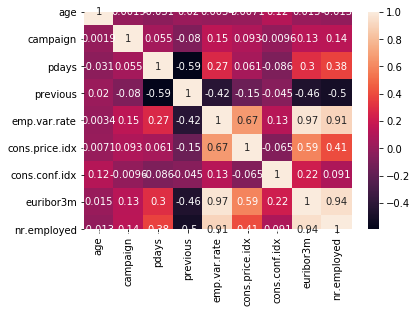

In [34]:
corrMatrix = X_train[numerical_variables].corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [35]:
corrMatrix

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000000,0.001874,-0.030667,0.019564,0.003416,0.007058,0.120738,0.014524,-0.013185
campaign,0.001874,1.000000,0.054736,-0.080058,0.148863,0.093217,-0.009648,0.132840,0.141519
pdays,-0.030667,0.054736,1.000000,-0.592263,0.274518,0.060996,-0.086349,0.300560,0.377937
previous,0.019564,-0.080058,-0.592263,1.000000,-0.422603,-0.152279,-0.045282,-0.457078,-0.504749
emp.var.rate,0.003416,0.148863,0.274518,-0.422603,1.000000,0.668260,0.128504,0.972258,0.906280
cons.price.idx,0.007058,0.093217,0.060996,-0.152279,0.668260,1.000000,-0.065407,0.593158,0.407473
cons.conf.idx,0.120738,-0.009648,-0.086349,-0.045282,0.128504,-0.065407,1.000000,0.216518,0.090705
euribor3m,0.014524,0.132840,0.300560,-0.457078,0.972258,0.593158,0.216518,1.000000,0.944963
nr.employed,-0.013185,0.141519,0.377937,-0.504749,0.906280,0.407473,0.090705,0.944963,1.000000


cons.price.idx and emp.var.rate, 
euribor3m and emp.var.rate,
euribor3m and cons.price.idx,
nr.employed and emp.var.rate, 
nr.employed and euribor3m 
highly correlated

In [36]:
#check numerical feature importance
fs = SelectKBest(score_func=f_regression, k=6)
fs.fit(X_train[numerical_variables], y_train)
X_train_fs_num = fs.transform(X_train[numerical_variables])
X_test_fs_num = fs.transform(X_test[numerical_variables])

In [37]:
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 25.101685
Feature 1: 132.207286
Feature 2: 3681.010920
Feature 3: 1728.891748
Feature 4: 2859.745685
Feature 5: 366.381952
Feature 6: 104.428841
Feature 7: 3080.120984
Feature 8: 4277.642745


In [38]:
numerical_variables

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [39]:
encoder = OneHotEncoder(sparse=False)
X_train_cat = encoder.fit_transform(X_train[categorical_variables])
X_test_cat = encoder.transform(X_test[categorical_variables])
fs = SelectKBest(score_func=chi2, k=20)
fs.fit(X_train_cat, y_train)
X_train_fs_cat = fs.transform(X_train_cat)
X_test_fs_cat = fs.transform(X_test_cat)
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

Feature 0: 20.704020
Feature 1: 125.911346
Feature 2: 7.351957
Feature 3: 1.201867
Feature 4: 0.001786
Feature 5: 251.615007
Feature 6: 0.339475
Feature 7: 28.895442
Feature 8: 253.739067
Feature 9: 1.915373
Feature 10: 7.040265
Feature 11: 0.517666
Feature 12: 4.221769
Feature 13: 24.867052
Feature 14: 71.512338
Feature 15: 2.601565
Feature 16: 1.866899
Feature 17: 15.252913
Feature 18: 57.539594
Feature 19: 1.082028
Feature 20: 1.446588
Feature 21: 0.305398
Feature 22: 57.757978
Feature 23: 15.309043
Feature 24: 61.249451
Feature 25: 230.213113
Feature 26: 0.380869
Feature 27: 1.750620
Feature 28: 0.021934
Feature 29: 1.436159
Feature 30: 0.008634
Feature 31: 0.021934
Feature 32: 0.075284
Feature 33: 225.178918
Feature 34: 392.473537
Feature 35: 159.781834
Feature 36: 1.954265
Feature 37: 208.947718
Feature 38: 21.988930
Feature 39: 3.758374
Feature 40: 613.009369
Feature 41: 241.435394
Feature 42: 3.568911
Feature 43: 567.170922
Feature 44: 492.060617
Feature 45: 0.416306
Feature 46

# Modeling

In [40]:
X_train.shape

(30891, 22)

In [41]:
# X_train = np.hstack((X_train_fs_num,X_train_fs_cat))
# X_test = np.hstack((X_test_fs_num,X_test_fs_cat))
X_train = np.concatenate((X_train_fs_num,X_train_fs_cat),axis=1)
X_test = np.concatenate((X_test_fs_num,X_test_fs_cat),axis=1)

In [42]:
# pca = PCA(n_components=20)
# X_train = pca.fit_transform(X_train)
# X_test = pca.transform(X_test)

In [43]:
X_train.shape

(30891, 26)

In [44]:
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)

In [45]:
dm = DummyClassifier(strategy='constant',constant=1)
dm.fit(X_train,y_train)
roc_auc_score(y_test,dm.predict(X_test))

0.5

baseline score is .5 ROC_AUC

In [46]:
lr = LogisticRegression(class_weight='balanced')
lda = LinearDiscriminantAnalysis()
gnb = GaussianNB()
rf = RandomForestClassifier(n_estimators=100)

In [47]:
model = SVC(gamma='scale', class_weight='balanced')
# wrap the model
calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(calibrated, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.791


In [48]:
models = [lr,lda,gnb,rf]
for model in models:
    calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3)
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(calibrated, X_test, y_test, scoring='roc_auc', cv=cv, n_jobs=-1)
    # summarize performance
    print(model, ' : Mean ROC AUC: %.3f' % mean(scores))

LogisticRegression(class_weight='balanced')  : Mean ROC AUC: 0.801
LinearDiscriminantAnalysis()  : Mean ROC AUC: 0.799
GaussianNB()  : Mean ROC AUC: 0.786
RandomForestClassifier()  : Mean ROC AUC: 0.763


For base models, it looks like logistic regression with balanced class weights performs the best